In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import geort
from geort.env.hand import HandKinematicModel

from manus.manus_data_mqtt import GloveMQTTSubscriber

In [2]:
class manus_geort_mocap:
    def __init__(self):
        self._manus_client = GloveMQTTSubscriber()
        time.sleep(1)
        # self._ data_indices = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
        
    def get(self):
        data_temp = np.array(self._manus_client._right_data["positions"])
        data = np.zeros_like(data_temp)
        data[:,0] = -data_temp[:,1]
        data[:,1] = -data_temp[:,0]
        data[:,2] = +data_temp[:,2]
        return data

In [3]:
# Your data collection loop.
mocap = manus_geort_mocap() # TODO(): your mocap system.
                           # Define a mocap.get() method.
                           # Apologies, you still have to do this...

**** MQTT INFO ****
Server IP (port): localhost (1883)
connected OK


# Data collection

In [ ]:
# Dataset Name
data_output_name = "human_LYS_right" # TODO(): Specify a name for this (e.g. your name)

data = []

data_len = 10000
for step in range(data_len):       # collect 5000 data points.
    hand_keypoint = mocap.get() # mocap.get() return [N, 3] numpy array.
    time.sleep(0.01)            # take a short break.
    
    data.append(hand_keypoint)
    
    if (step+1)%100==0:
        clear_output(wait=True)
        print(f'{(step+1)/data_len * 100} %')

# finish data collection.
geort.save_human_data(data, data_output_name)


# Train

In [10]:
# !cd ../ && python ./geort/trainer.py -hand kistar_right -human_data human_LYS_right -ckpt_tag geort_LYS_right
!python ./geort/trainer.py -hand kistar_right -human_data human_LYS_right -ckpt_tag geort_LYS_right_kistar --w_pinch 15.0 --w_curvature 1.0 --w_chamfer 40
# !python ../geort/trainer.py -hand allegro_right -human_data human_LYS_right -ckpt_tag geort_LYS_right_allegro

User-to-Sim Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Sim-to-User Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[ 0.       -1.5708    0.        0.       -0.261799  0.        0.
  0.       -0.081799  0.        0.        0.       -0.08      0.
  0.        0.      ] [1.5708   0.15708  1.5708   1.5708   0.08     1.5708   1.5708   1.5708
 0.081799 1.5708   1.5708   1.5708   0.261799 1.5708   1.5708   1.5708  ]
0 thumb_joint_0 <sapien.core.pysapien.Joint object at 0x7d681aaff770> 0.0 1.5708
1 thumb_joint_1 <sapien.core.pysapien.Joint object at 0x7d681aaff7b0> -1.5708 0.15708
2 thumb_joint_2 <sapien.core.pysapien.Joint object at 0x7d681aaff7f0> 0.0 1.5708
3 thumb_joint_3 <sapien.core.pysapien.Joint object at 0x7d681aaff830> 0.0 1.5708
4 index_joint_0 <sapien.core.pysapien.Joint object at 0x7d681aaff870> -0.261799 0.08
5 index_joint_1 <sapien.core.pysapien.Joint object at 0x7d681aaff8b0> 0.0 1.5708
6 index_joint_2 <sapien.core.pysapien.Joint object at 0x7d681a

In [ ]:
# stable-v1
# -hand kistar_right -human_data human_LYS_right -ckpt_tag geort_LYS_right_kistar --w_pinch 15.0 --w_curvature 1.0 --w_chamfer 80
# stable-v2
# -hand kistar_right -human_data human_LYS_right -ckpt_tag geort_LYS_right_kistar --w_pinch 15.0 --w_curvature 1.0 --w_chamfer 50
# stable-v3 (use kistar urdf with reduced middle abduction/abbduction range)
# -hand kistar_right -human_data human_LYS_right -ckpt_tag geort_LYS_right_kistar --w_pinch 15.0 --w_curvature 1.0 --w_chamfer 50
# stable-v4 (use kistar urdf with reduced middle abduction/abbduction range)
# -hand kistar_right -human_data human_LYS_right -ckpt_tag geort_LYS_right_kistar --w_pinch 15.0 --w_curvature 1.0 --w_chamfer 40

In [ ]:
# !cd ../ && python ./geort/mocap/replay_evaluation.py -hand kistar_right -ckpt_tag geort_LYS_right -data human_LYS_right
!python ./geort/mocap/replay_evaluation.py -hand kistar_right -ckpt_tag geort_LYS_right_kistar -data human_LYS_right

# Run

In [57]:
checkpoint_tag = 'kistar_right_stable-V3'          # TODO: your checkpoint name, assume it is 'TAG'
model = geort.load_model(checkpoint_tag, epoch=-1)  # set epoch=-1 to use the last model.

# Load Hand Model
hand_name = 'kistar_right'
config = geort.utils.config_utils.get_config(hand_name)
hand_model = HandKinematicModel.build_from_config(config, render=True)
viewer_env = hand_model.get_viewer_env()

steps = 0
while True:
    viewer_env.update()

    steps += 1
    qpos = model.forward(mocap.get()) # This is the retargeted qpos. 
                                      # (Note: unnormalized joint angle)
    hand_model.set_qpos_target(qpos)

[[4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [0, 1, 2, 3]]
Enable Render Mode.
User-to-Sim Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Sim-to-User Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[ 0.       -1.5708    0.        0.       -0.261799  0.        0.
  0.       -0.081799  0.        0.        0.       -0.08      0.
  0.        0.      ] [1.5708   0.15708  1.5708   1.5708   0.08     1.5708   1.5708   1.5708
 0.081799 1.5708   1.5708   1.5708   0.261799 1.5708   1.5708   1.5708  ]
0 thumb_joint_0 <sapien.core.pysapien.Joint object at 0x7be5a72683b0> 0.0 1.5708
1 thumb_joint_1 <sapien.core.pysapien.Joint object at 0x7be5a7269530> -1.5708 0.15708
2 thumb_joint_2 <sapien.core.pysapien.Joint object at 0x7be5a7268cf0> 0.0 1.5708
3 thumb_joint_3 <sapien.core.pysapien.Joint object at 0x7be5a7269c30> 0.0 1.5708
4 index_joint_0 <sapien.core.pysapien.Joint object at 0x7be5a726ac70> -0.261799 0.08
5 index_joint_1 <sapien.core.pysapien.Joint object at 0x7be5

/home/rnbmarch/anaconda3/envs/geort/lib/python3.10/site-packages/sapien/core/__init__.py:23: UserWarning: VulkanRenderer is renamed SapienRenderer now
  warn("VulkanRenderer is renamed SapienRenderer now")
[2025-08-05 00:16:35.730] [SAPIEN] [warning] A second engine will share the same internal structures with the first one. Arguments passed to constructor will be ignored.
[2025-08-05 00:16:35.730] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2025-08-05 00:16:35.730] [SAPIEN] [warning] Setting renderer more than once should be avoided.


NameError: name 'mocap' is not defined

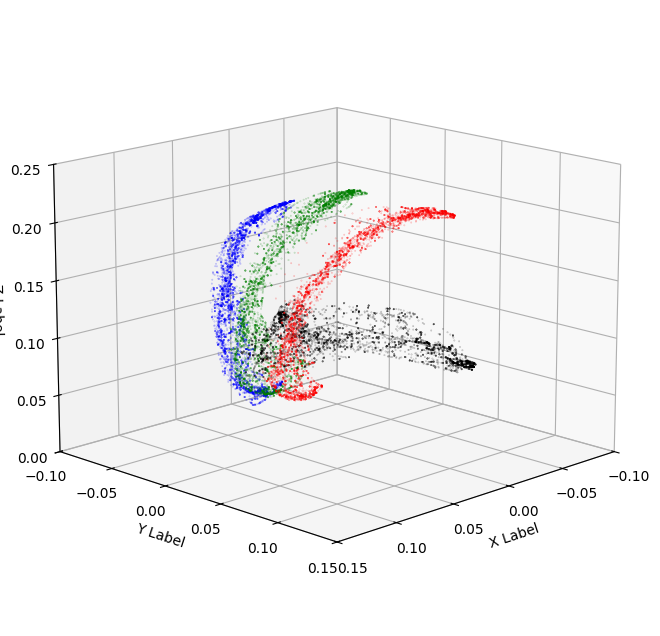

In [45]:
data_plot = np.array(np.load("./data/human_LYS_right.npy"))
# data_plot = np.array(np.load("./data/human_alex.npy"))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(data_plot[:,4,0], data_plot[:,4,1], data_plot[:,4,2], s=0.1, c='k', alpha=0.3)
ax.scatter(data_plot[:,9,0], data_plot[:,9,1], data_plot[:,9,2], s=0.1, c='r', alpha=0.3)
ax.scatter(data_plot[:,14,0], data_plot[:,14,1], data_plot[:,14,2], s=0.1, c='g', alpha=0.3)
ax.scatter(data_plot[:,19,0], data_plot[:,19,1], data_plot[:,19,2], s=0.1, c='b', alpha=0.3)

# ax.scatter(data_plot[:,4,0], data_plot[:,4,1], data_plot[:,4,2], s=0.1, c='k', alpha=0.5)
# ax.scatter(data_plot[:,8,0], data_plot[:,8,1], data_plot[:,8,2], s=0.1, c='r', alpha=0.5)
# ax.scatter(data_plot[:,12,0], data_plot[:,12,1], data_plot[:,12,2], s=0.1, c='g', alpha=0.5)
# ax.scatter(data_plot[:,16,0], data_plot[:,16,1], data_plot[:,16,2], s=0.1, c='b', alpha=0.5)

ax.axis('equal')
ax.view_init(elev=15, azim=45) 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim([-0.10, 0.15])
ax.set_ylim([-0.10, 0.15])
ax.set_zlim([0.00, 0.25])
# ax.set_box_aspect(None, zoom=0.85)
# plt.tight_layout()
plt.show()


# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot()

# ax.scatter(data_plot[:,4,0], data_plot[:,4,2], s=0.1, c='k', alpha=0.3)
# ax.scatter(data_plot[:,9,0], data_plot[:,9,2], s=0.1, c='r', alpha=0.3)
# ax.scatter(data_plot[:,14,0], data_plot[:,14,2], s=0.1, c='g', alpha=0.3)
# ax.scatter(data_plot[:,19,0], data_plot[:,19,2], s=0.1, c='b', alpha=0.3)

# # ax.scatter(data_plot[:,4,0], data_plot[:,4,2], s=0.1, c='k', alpha=0.5)
# # ax.scatter(data_plot[:,8,0], data_plot[:,8,2], s=0.1, c='r', alpha=0.5)
# # ax.scatter(data_plot[:,12,0], data_plot[:,12,2], s=0.1, c='g', alpha=0.5)
# # ax.scatter(data_plot[:,16,0], data_plot[:,16,2], s=0.1, c='b', alpha=0.5)

# ax.axis('equal')
# ax.set_xlabel('X Label')
# ax.set_ylabel('Z Label')

# plt.show()

[[4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [0, 1, 2, 3]]
User-to-Sim Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Sim-to-User Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[ 0.       -1.5708    0.        0.       -0.261799  0.        0.
  0.       -0.081799  0.        0.        0.       -0.08      0.
  0.        0.      ] [1.5708   0.15708  1.5708   1.5708   0.08     1.5708   1.5708   1.5708
 0.081799 1.5708   1.5708   1.5708   0.261799 1.5708   1.5708   1.5708  ]
0 thumb_joint_0 <sapien.core.pysapien.Joint object at 0x7be5a71cd130> 0.0 1.5708
1 thumb_joint_1 <sapien.core.pysapien.Joint object at 0x7be5a7039a70> -1.5708 0.15708
2 thumb_joint_2 <sapien.core.pysapien.Joint object at 0x7be5a70e6ff0> 0.0 1.5708
3 thumb_joint_3 <sapien.core.pysapien.Joint object at 0x7be5a6e23d70> 0.0 1.5708
4 index_joint_0 <sapien.core.pysapien.Joint object at 0x7be5a6e22270> -0.261799 0.08
5 index_joint_1 <sapien.core.pysapien.Joint object at 0x7be5a6e23ab0> 0.0 1.5708

[2025-08-05 00:15:34.449] [SAPIEN] [warning] A second engine will share the same internal structures with the first one. Arguments passed to constructor will be ignored.


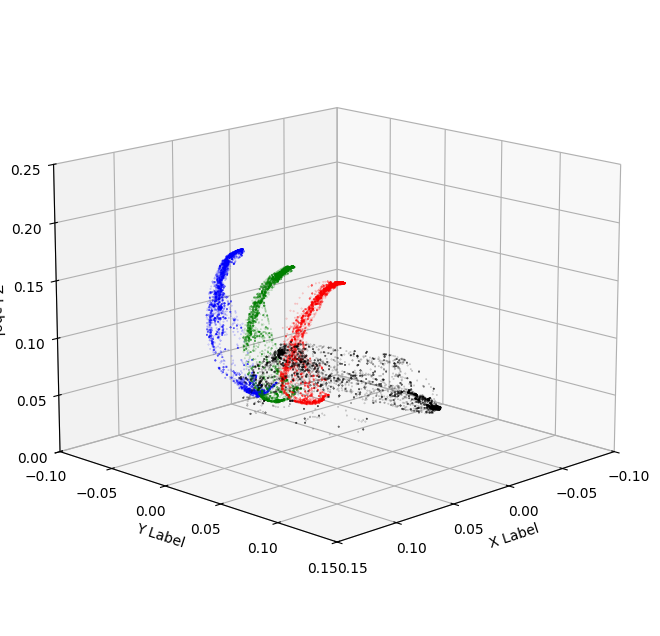

In [56]:
checkpoint_tag = 'kistar_right_stable-V3'          # TODO: your checkpoint name, assume it is 'TAG'
model = geort.load_model(checkpoint_tag, epoch=-1)  # set epoch=-1 to use the last model.

from geort.trainer import GeoRTTrainer

hand_name = 'kistar_right'
config = geort.utils.config_utils.get_config(hand_name)
trainer = GeoRTTrainer(config)

info = trainer.get_keypoint_info()
trainer.hand.initialize_keypoint(keypoint_link_names=info["link"], keypoint_offsets=info["offset"])
    
data_plot = np.array(np.load("./data/human_LYS_right.npy"))
thumb_data = []
index_data = []
middle_data = []
ring_data = []

for data in data_plot:
    qpos = model.forward(data)
    tpos = trainer.hand.keypoint_from_qpos(qpos)
    thumb_data.append(tpos["thumb_tip_end"])
    index_data.append(tpos["index_tip_end"])
    middle_data.append(tpos["middle_tip_end"])
    ring_data.append(tpos["ring_tip_end"])
    
thumb_data = np.array(thumb_data)
index_data = np.array(index_data)
middle_data = np.array(middle_data)
ring_data = np.array(ring_data)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(thumb_data[:,0], thumb_data[:,1], thumb_data[:,2], s=0.1, c='k', alpha=0.3)
ax.scatter(index_data[:,0], index_data[:,1], index_data[:,2], s=0.1, c='r', alpha=0.3)
ax.scatter(middle_data[:,0], middle_data[:,1], middle_data[:,2], s=0.1, c='g', alpha=0.3)
ax.scatter(ring_data[:,0], ring_data[:,1], ring_data[:,2], s=0.1, c='b', alpha=0.3)

ax.axis('equal')
ax.view_init(elev=15, azim=45) 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_xlim([-0.10, 0.15])
ax.set_ylim([-0.10, 0.15])
ax.set_zlim([0.00, 0.25])

plt.show()

[2025-08-05 07:48:25.758] [SAPIEN] [warning] A second engine will share the same internal structures with the first one. Arguments passed to constructor will be ignored.


User-to-Sim Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Sim-to-User Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[ 0.       -1.5708    0.        0.       -0.261799  0.        0.
  0.       -0.081799  0.        0.        0.       -0.08      0.
  0.        0.      ] [1.5708   0.15708  1.5708   1.5708   0.08     1.5708   1.5708   1.5708
 0.081799 1.5708   1.5708   1.5708   0.261799 1.5708   1.5708   1.5708  ]
0 thumb_joint_0 <sapien.core.pysapien.Joint object at 0x70098a8fc770> 0.0 1.5708
1 thumb_joint_1 <sapien.core.pysapien.Joint object at 0x700986a803f0> -1.5708 0.15708
2 thumb_joint_2 <sapien.core.pysapien.Joint object at 0x700986a83170> 0.0 1.5708
3 thumb_joint_3 <sapien.core.pysapien.Joint object at 0x700986a814f0> 0.0 1.5708
4 index_joint_0 <sapien.core.pysapien.Joint object at 0x700986a80270> -0.261799 0.08
5 index_joint_1 <sapien.core.pysapien.Joint object at 0x700986787230> 0.0 1.5708
6 index_joint_2 <sapien.core.pysapien.Joint object at 0x700986

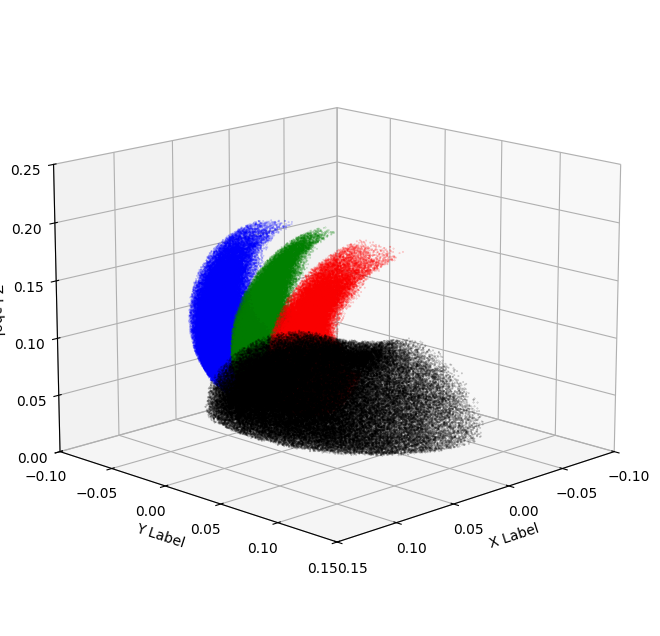

In [26]:
from geort.trainer import GeoRTTrainer

hand_name = 'kistar_right'
config = geort.utils.config_utils.get_config(hand_name)

trainer = GeoRTTrainer(config)
fk_dataset = trainer.get_robot_kinematics_dataset()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

# thumb_data = fk_dataset.export_robot_pointcloud(['thumb_tip_end'])[0][::5,:]
# index_data = fk_dataset.export_robot_pointcloud(['index_tip_end'])[0][::5,:]
# middle_data = fk_dataset.export_robot_pointcloud(['middle_tip_end'])[0][::5,:]
# ring_data = fk_dataset.export_robot_pointcloud(['ring_tip_end'])[0][::5,:]

thumb_data = fk_dataset.export_robot_pointcloud(['thumb_tip_end'])[0]
index_data = fk_dataset.export_robot_pointcloud(['index_tip_end'])[0]
middle_data = fk_dataset.export_robot_pointcloud(['middle_tip_end'])[0]
ring_data = fk_dataset.export_robot_pointcloud(['ring_tip_end'])[0]

np.save('./data/KISTAR_thumb_data.npy', thumb_data)
np.save('./data/KISTAR_index_data.npy', index_data)
np.save('./data/KISTAR_middle_data.npy', middle_data)
np.save('./data/KISTAR_ring_data.npy', ring_data)

ax.scatter(thumb_data[:,0], thumb_data[:,1], thumb_data[:,2], s=0.1, c='k', alpha=0.3)
ax.scatter(index_data[:,0], index_data[:,1], index_data[:,2], s=0.1, c='r', alpha=0.3)
ax.scatter(middle_data[:,0], middle_data[:,1], middle_data[:,2], s=0.1, c='g', alpha=0.3)
ax.scatter(ring_data[:,0], ring_data[:,1], ring_data[:,2], s=0.1, c='b', alpha=0.3)

# ax.scatter(data_plot[:,4,0], data_plot[:,4,1], data_plot[:,4,2], s=0.1, c='brown', alpha=0.5)
# ax.scatter(data_plot[:,9,0], data_plot[:,9,1], data_plot[:,9,2], s=0.1, c='m', alpha=0.5)
# ax.scatter(data_plot[:,14,0], data_plot[:,14,1], data_plot[:,14,2], s=0.1, c='lawngreen', alpha=0.5)
# ax.scatter(data_plot[:,19,0], data_plot[:,19,1], data_plot[:,19,2], s=0.1, c='cornflowerblue', alpha=0.5)

ax.axis('equal')
ax.view_init(elev=15, azim=45) 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_xlim([-0.10, 0.15])
ax.set_ylim([-0.10, 0.15])
ax.set_zlim([0.00, 0.25])

plt.show()

In [6]:
import pybullet as p

p.connect(p.GUI)
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)
p.configureDebugVisualizer(p.COV_ENABLE_SHADOWS, 1)
p.configureDebugVisualizer(p.COV_ENABLE_RGB_BUFFER_PREVIEW, 0)
p.configureDebugVisualizer(p.COV_ENABLE_DEPTH_BUFFER_PREVIEW, 0)
p.configureDebugVisualizer(p.COV_ENABLE_SEGMENTATION_MARK_PREVIEW, 0)

p.setPhysicsEngineParameter(enableFileCaching=0)
p.resetDebugVisualizerCamera(cameraDistance=0.4, cameraYaw=145, cameraPitch=-30, cameraTargetPosition=[0, 0, 0])

p.loadURDF("./assets/kistar_right/model.urdf")

pybullet build time: Nov 28 2023 23:45:17


0

In [18]:
p.addUserDebugPoints(pointPositions=thumb_data, pointColorsRGB=[(0,0,0)]*len(thumb_data), pointSize=1, lifeTime=5*0)
p.addUserDebugPoints(pointPositions=index_data, pointColorsRGB=[(1,0,0)]*len(thumb_data), pointSize=1, lifeTime=5*0)
p.addUserDebugPoints(pointPositions=middle_data, pointColorsRGB=[(0,1,0)]*len(thumb_data), pointSize=1, lifeTime=5*0)
p.addUserDebugPoints(pointPositions=ring_data, pointColorsRGB=[(0,0,1)]*len(thumb_data), pointSize=1, lifeTime=5*0)

35

In [58]:
p.disconnect()

In [14]:
checkpoint_tag = 'kistar_right_stable-V3'          # TODO: your checkpoint name, assume it is 'TAG'
model = geort.load_model(checkpoint_tag, epoch=-1)  # set epoch=-1 to use the last model.

from geort.trainer import GeoRTTrainer

hand_name = 'kistar_right'
config = geort.utils.config_utils.get_config(hand_name)
trainer = GeoRTTrainer(config)

info = trainer.get_keypoint_info()
trainer.hand.initialize_keypoint(keypoint_link_names=info["link"], keypoint_offsets=info["offset"])


task_name = 'teleop_250805_stapler'

joint_positions = np.load(f'./{task_name}/joint_positions.npy')

thumb_data = []
index_data = []
middle_data = []
ring_data = []

for joint_position in joint_positions:
    joint_position[13] += 9000
    tpos = trainer.hand.keypoint_from_qpos(joint_position*np.pi/2/8192)
    thumb_data.append(tpos["thumb_tip_end"])
    index_data.append(tpos["index_tip_end"])
    middle_data.append(tpos["middle_tip_end"])
    ring_data.append(tpos["ring_tip_end"])

thumb_data = np.array(thumb_data)
index_data = np.array(index_data)
middle_data = np.array(middle_data)
ring_data = np.array(ring_data)

task_positions = np.hstack((thumb_data, index_data, middle_data, ring_data))

np.save(f'./{task_name}/task_positions.npy', task_positions)

[[4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [0, 1, 2, 3]]
User-to-Sim Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Sim-to-User Joint [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[ 0.       -1.5708    0.        0.       -0.261799  0.        0.
  0.       -0.081799  0.        0.        0.       -0.08      0.
  0.        0.      ] [1.5708   0.15708  1.5708   1.5708   0.08     1.5708   1.5708   1.5708
 0.081799 1.5708   1.5708   1.5708   0.261799 1.5708   1.5708   1.5708  ]
0 thumb_joint_0 <sapien.core.pysapien.Joint object at 0x77879a4c8330> 0.0 1.5708
1 thumb_joint_1 <sapien.core.pysapien.Joint object at 0x77879a4cbe70> -1.5708 0.15708
2 thumb_joint_2 <sapien.core.pysapien.Joint object at 0x77879a4ca730> 0.0 1.5708
3 thumb_joint_3 <sapien.core.pysapien.Joint object at 0x77879a4ca4b0> 0.0 1.5708
4 index_joint_0 <sapien.core.pysapien.Joint object at 0x77879a4cadb0> -0.261799 0.08
5 index_joint_1 <sapien.core.pysapien.Joint object at 0x77879a4cb630> 0.0 1.5708

[2025-08-05 14:20:08.777] [SAPIEN] [warning] A second engine will share the same internal structures with the first one. Arguments passed to constructor will be ignored.


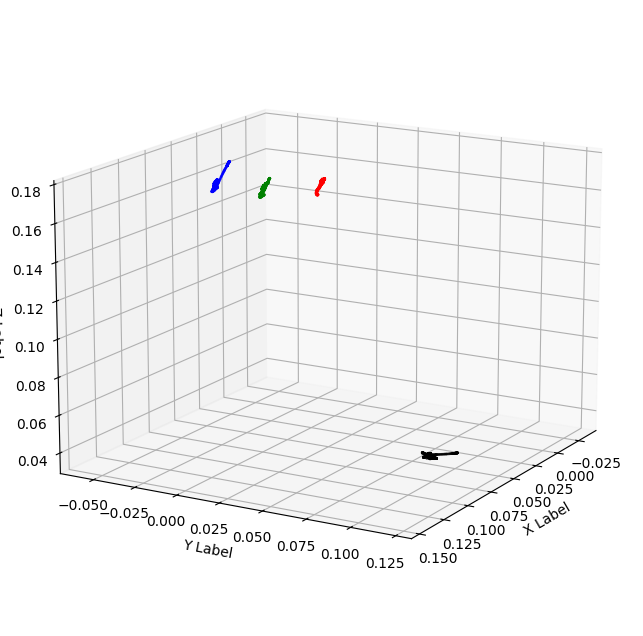

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(thumb_data[:,0], thumb_data[:,1], thumb_data[:,2], s=1, c='k', alpha=0.7)
ax.scatter(index_data[:,0], index_data[:,1], index_data[:,2], s=1, c='r', alpha=0.7)
ax.scatter(middle_data[:,0], middle_data[:,1], middle_data[:,2], s=1, c='g', alpha=0.7)
ax.scatter(ring_data[:,0], ring_data[:,1], ring_data[:,2], s=1, c='b', alpha=0.7)

ax.axis('equal')
ax.view_init(elev=15, azim=30) 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# ax.set_xlim([-0.10, 0.15])
# ax.set_ylim([-0.10, 0.15])
# ax.set_zlim([0.00, 0.25])

plt.show()